## Наивная реализация

Пребор всех возможных путей

Асимптотика : $O((n-1)!)$

In [1]:
import networkx as nx

G=nx.Graph()
e=[('a','b',0.3),('b','c',0.9),('a','c',0.5),('c','d',1.2), ('a','d',3)]
G.add_weighted_edges_from(e)

start = 'a'
finish = 'd'
minpath = []
path = [start]
min_len = 1000
n = len(G.nodes())

def naive_algo(vertex, prev_vertices, old_len):
    global min_len
    global minpath
    global n
    for next_vertex in G.neighbors(vertex):
        if next_vertex not in prev_vertices:
            current_len = old_len
            current_len += G[vertex][next_vertex]['weight']
            path = prev_vertices.copy()
            path.append(next_vertex)
            
            if (next_vertex == finish and len(path) == n):
                if (current_len < min_len):
                    minpath = path
                    min_len = current_len
            else:
                naive_algo(next_vertex, path, current_len)
                
naive_algo(start, path, 0)

print(min_len)
print(minpath)

2.4
['a', 'b', 'c', 'd']


In [2]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx.algorithms.approximation
import networkx.algorithms.euler
from mpl_toolkits.basemap import Basemap

In [3]:
def draw_graph(G, title, Coord_X, Coord_Y, file_name, s, t):
    '''
    Функция для рисования графа на карте
    '''
    fig = plt.figure(figsize=(15, 6))
    m = Basemap(
        projection='lcc', 
        resolution='l',
        width=9E6, height=5E6, 
        lat_0=65, lon_0=90,
        suppress_ticks=True
    )

    m.etopo(scale=0.5, alpha=0.5)

    mx, my = m(Coord_X, Coord_Y)
    pos = {}
    for i in range(len(Coord_X)):
        pos[i] = (mx[i], my[i])


    nx.draw_networkx_nodes(G = G, pos = pos, nodelist = G.nodes(), node_color = 'r', node_size=25)
    nx.draw_networkx_edges(G = G, pos = pos, edge_color='b', alpha=1, arrows = False)
    
    pos_ = {}
    pos_[s], pos_[t] = pos[s], pos[t]

    nx.draw_networkx_nodes(G = G, pos = pos_, nodelist = [s,t], node_color = '#FFC300', node_size=30)
    
    m.drawstates(linewidth = 0.2)

    plt.tight_layout()
    plt.title(title, fontsize=18)
    plt.savefig(file_name)
    plt.show()


**Будем строить гамильтонов путь для городов России с населением >= 100.000**

In [4]:
# считываем данные городов
russia_incidents = pd.read_csv('ru.csv')
# фильтруем города с наслением меньше 100.000 человек
russia_incidents = russia_incidents[russia_incidents['population'] >= 100000]

Coord_X = list(russia_incidents.lng)
Coord_Y = list(russia_incidents.lat)

In [7]:
G=nx.Graph()
for i in range(len(Coord_X)):
    for j in range(len(Coord_Y)):
        G.add_edge(i,j,weight=np.sqrt((float(Coord_X[i])-float(Coord_X[j]))**2
                                      + (float(Coord_Y[i])-float(Coord_Y[j]))**2))

**1. Посмотрим минимальное остовное дерево MST. В данной задаче будем использовать алгоритм Крускала
Этот алгоритм работает за полиномиальное время от |V |.**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


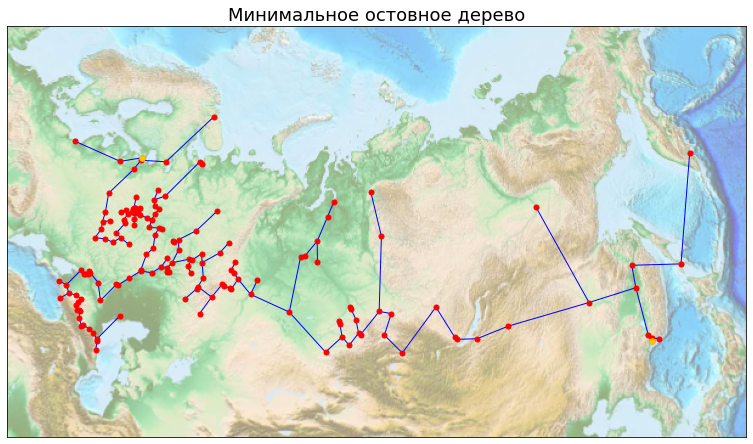

In [8]:
MST = nx.minimum_spanning_tree(G)

draw_graph(MST, "Минимальное остовное дерево", Coord_X, Coord_Y, "mst.svg", 1, 25)

**2.Формируем список вершин W, содержащий вершины нечетных степеней.**

In [9]:
W = []
s, t = 1, 25
for node in MST.nodes() :
    if (MST.degree[node] % 2 != 0 and not(node==s or node==t)):
        W.append(node)
        
if (MST.degree[s] % 2 == 0):
        W.append(s)
if (MST.degree[t] % 2 == 0):
        W.append(t)

**3. Строим совершенное паросочетание Match на подграфе, содержащем
вершины W, с помощью алгоритма Эдмонса**

In [16]:
sub_G = nx.subgraph(G, W).copy()

for u,v,d in sub_G.edges(data=True):
    if d['weight'] != 0:
        d['weight'] = 1/d['weight']

Match = nx.max_weight_matching(sub_G)

**4. Теперь составим новый граф G‘, состоящий из ребер из MST U Match.
Заметим, что полученный граф будет эйлеровым.
начало – наша
вершина s, а конец – наша вершина t. Полученный граф назовем
EulerGraph**

In [18]:
Match = [pair for pair in Match]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


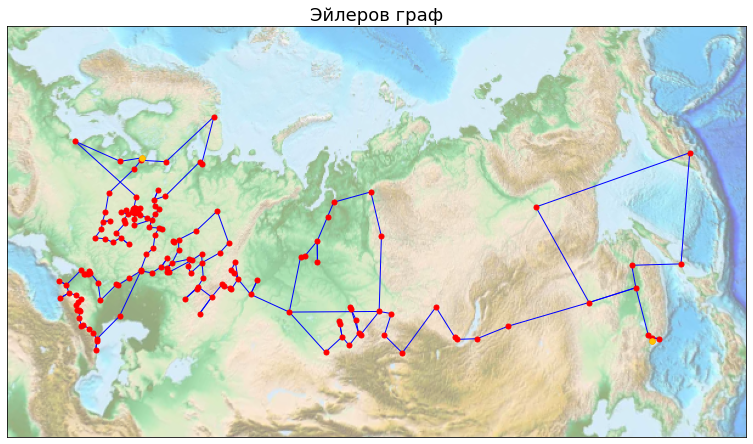

In [19]:
start = 1
finish = 25

union = Match
for edge in MST.edges():
    union.append(edge)

EulerGraph = nx.MultiGraph()
EulerGraph.add_edges_from(union)

draw_graph(EulerGraph, "Эйлеров граф", Coord_X, Coord_Y, "euler_graph.svg", start, finish)

**5. Совершим обход по EulerGraph. Путь, который мы найдем, обозначим
EulerPath.**

In [20]:
EP = [edge for edge in nx.eulerian_path(EulerGraph, source=start)]
EP_nodes = []
for edge in EP:
    EP_nodes.append(edge[0])
EP_nodes.append(EP[-1][1])
print(EP_nodes)

[25, 159, 118, 159, 109, 23, 77, 98, 104, 63, 89, 23, 89, 54, 43, 22, 86, 83, 146, 103, 11, 161, 85, 105, 113, 149, 158, 72, 158, 50, 133, 7, 121, 20, 165, 2, 20, 95, 97, 29, 27, 156, 97, 30, 161, 7, 58, 17, 58, 110, 3, 137, 52, 110, 119, 6, 117, 112, 45, 84, 45, 69, 116, 28, 69, 10, 130, 12, 122, 78, 36, 74, 132, 37, 74, 5, 145, 80, 33, 115, 148, 130, 19, 33, 8, 168, 18, 145, 18, 106, 21, 106, 99, 88, 150, 57, 14, 166, 108, 81, 154, 81, 111, 9, 131, 9, 76, 15, 73, 15, 124, 46, 124, 100, 42, 142, 139, 128, 153, 120, 75, 64, 141, 67, 125, 26, 143, 138, 26, 32, 88, 16, 34, 60, 163, 82, 4, 82, 151, 127, 47, 71, 24, 101, 59, 101, 61, 102, 53, 66, 70, 87, 91, 56, 48, 169, 62, 169, 41, 49, 90, 13, 35, 68, 35, 164, 135, 38, 134, 147, 55, 134, 65, 129, 96, 155, 144, 123, 31, 127, 51, 140, 114, 167, 114, 144, 162, 160, 92, 136, 40, 157, 96, 157, 92, 94, 0, 152, 79, 107, 126, 107, 44, 39, 93, 1, 87, 1]


**6. Сконструируем гамильтонов цикл AlgoHamPath по вершинам исходного графа G в порядке, в котором они встречаются в списке вершин
EulerPath**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


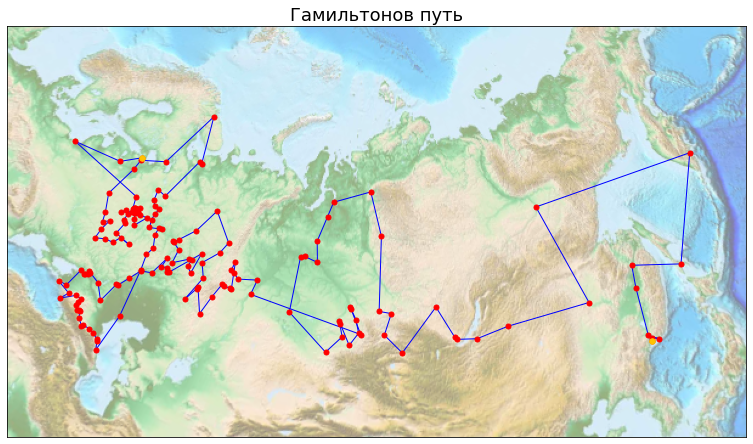

In [21]:
AlgoHamPath = []
for node in EP_nodes:
    if not(node in AlgoHamPath) and node != EP_nodes[-1]:
        AlgoHamPath.append(node)
        
AlgoHamPath.append(EP_nodes[-1])
edges = [(AlgoHamPath[i], AlgoHamPath[i+1]) for i in range(len(AlgoHamPath)-1)]

path = nx.Graph()
path.add_edges_from(edges)
draw_graph(path, "Гамильтонов путь", Coord_X, Coord_Y, "ham_path.svg", s, t)

In [22]:
sum_distance=0
for i in range(len(AlgoHamPath)-1):
    sum_distance += G[AlgoHamPath[i]%len(G.nodes())][AlgoHamPath[(i+1)]%len(G.nodes())]['weight']
print("Длина пути: {}".format(sum_distance))
print("Путь: {}".format(AlgoHamPath))

Длина пути: 429.34128974466057
Путь: [25, 159, 118, 109, 23, 77, 98, 104, 63, 89, 54, 43, 22, 86, 83, 146, 103, 11, 161, 85, 105, 113, 149, 158, 72, 50, 133, 7, 121, 20, 165, 2, 95, 97, 29, 27, 156, 30, 58, 17, 110, 3, 137, 52, 119, 6, 117, 112, 45, 84, 69, 116, 28, 10, 130, 12, 122, 78, 36, 74, 132, 37, 5, 145, 80, 33, 115, 148, 19, 8, 168, 18, 106, 21, 99, 88, 150, 57, 14, 166, 108, 81, 154, 111, 9, 131, 76, 15, 73, 124, 46, 100, 42, 142, 139, 128, 153, 120, 75, 64, 141, 67, 125, 26, 143, 138, 32, 16, 34, 60, 163, 82, 4, 151, 127, 47, 71, 24, 101, 59, 61, 102, 53, 66, 70, 87, 91, 56, 48, 169, 62, 41, 49, 90, 13, 35, 68, 164, 135, 38, 134, 147, 55, 65, 129, 96, 155, 144, 123, 31, 51, 140, 114, 167, 162, 160, 92, 136, 40, 157, 94, 0, 152, 79, 107, 126, 44, 39, 93, 1]


**Наивный алгоритм**

Искать истинное значение длины наименшего пути мы не будет, т.к

- Возможных вариантов путей: $169! \sim \sqrt{2 \pi * 169}(\frac{169}{e})^{169} < 4.3 * 10^{304}$
- Производительность компьютера: $10^{11}$ арифмитических операций в секунду
- Чтобы решить задачу понадобится $4.3 * 10^{293}$ секунды, это примерно $10^{286}$ лет

Долго.

## Тесты

In [23]:
minpath = []
min_len = 1000000

def naive_algo(G, start, finish):
    """
    Наивный алгортим (перебор путей)
    return: (кратчайший путь, длина этого пути)
    """
    global min_len
    global minpath
    start = 1
    finish = 4
    minpath = []
    path = [start]
    min_len = 1000000
    n = len(G.nodes())

    def find_path(vertex, prev_vertices, old_len):
        """
        Вспомогательная функция для поиска пути
        """
        global min_len
        global minpath
        for next_vertex in G.neighbors(vertex):
            if next_vertex not in prev_vertices:
                current_len = old_len
                current_len += G[vertex][next_vertex]['weight']
                path = prev_vertices.copy()
                path.append(next_vertex)

                if (next_vertex == finish and len(path) == n):

                    if (current_len < min_len):
                        minpath = path
                        min_len = current_len
                else:
                    find_path(next_vertex, path, current_len)
        return (minpath, min_len)
    return find_path(start, path, 0)

In [24]:
def opt_algo(G, start, finish):
    """
    Описанный выше алгоритм, дающий 5/3-приближение
    return: гамильтонов путь из start в finish
    """
    MST = nx.minimum_spanning_tree(G)
    
    W = []
    for node in MST.nodes() :
        if (MST.degree[node] % 2 != 0 and not(node==start or node==finish)):
            W.append(node)
        
    if (MST.degree[start] % 2 == 0):
        W.append(start)
    if (MST.degree[finish] % 2 == 0):
        W.append(finish)
            
    sub_G = nx.subgraph(G, W).copy()
    #sub_G.remove_edges_from(MST.edges())

    for u,v,d in sub_G.edges(data=True):
        if d['weight'] != 0:
            d['weight'] = 1/d['weight']

    Match = nx.max_weight_matching(sub_G)
    Match = [pair for pair in Match]

    union = Match
    for edge in MST.edges():
        union.append(edge)

    EulerGraph = nx.MultiGraph()
    EulerGraph.add_edges_from(union)
    print("Eluer {}".format(EulerGraph.edges()))
    
    EP = [edge for edge in nx.eulerian_path(EulerGraph, source=start)]
    EP_nodes = []
    for edge in EP:
        EP_nodes.append(edge[0])
    EP_nodes.append(EP[-1][1])
    
    AlgoHamPath = []
    for node in EP_nodes:
        if not(node in AlgoHamPath) and node != EP_nodes[-1]:
            AlgoHamPath.append(node)
        
    AlgoHamPath.append(EP_nodes[-1])

    print("AlgoHamPath {}".format(AlgoHamPath))
    sum_distance=0
    for i in range(len(AlgoHamPath)):
        id0 = AlgoHamPath[i]
        id1 = AlgoHamPath[(i+1)%len(AlgoHamPath)]
        sum_distance += G[id0][id1]['weight']
    
    return (AlgoHamPath, sum_distance)

In [25]:
def build_graph(size):
    """
    Функция для посторения графа с size вершинами
    """
    # считываем данные городов
    russia_incidents = pd.read_csv('ru.csv')
    # берем первые size городов
    russia_incidents = russia_incidents.head(size)

    Coord_X = list(russia_incidents.lng)
    Coord_Y = list(russia_incidents.lat)
    
    G=nx.Graph()
    for i in range(len(Coord_X)):
        for j in range(len(Coord_Y)):
            G.add_edge(i,j,weight=np.sqrt((float(Coord_X[i])-float(Coord_X[j]))**2
                                      + (float(Coord_Y[i])-float(Coord_Y[j]))**2))
    return G

- tests_data {кол-во узлов: [
        время работы наивного алгоритма,
        время работы нашего алгоритма,
        длина пути наивного алгоритма,
        длина пути нашего алгоритма
]}

In [26]:
import time


tests_data = {}
sizes = [5, 8, 10, 11, 12]
start = 1
finish = 2
for size in sizes:
    print(size)
    G = build_graph(size)
    start = time.time()
    naive_path, naive_len = naive_algo(G, 0, 1)
    end = time.time()
    naive_time = end - start
    
    start = time.time()
    opt_path, opt_len = opt_algo(G, 0, 1)
    end = time.time()
    opt_time = end - start  
        
    tests_data[size] = [naive_time, opt_time, naive_len, opt_len]
    
print(tests_data)

5
Eluer [(0, 2), (0, 4), (0, 1), (2, 3), (4, 3)]
AlgoHamPath [1, 4, 3, 2, 0]
8
Eluer [(0, 2), (0, 4), (0, 1), (2, 7), (4, 5), (7, 6), (3, 6), (3, 5)]
AlgoHamPath [1, 4, 5, 3, 6, 7, 2, 0]
10
Eluer [(9, 2), (9, 0), (2, 7), (0, 4), (0, 1), (4, 5), (7, 6), (3, 6), (3, 8), (8, 5)]
AlgoHamPath [1, 4, 5, 8, 3, 6, 7, 2, 9, 0]
11
Eluer [(9, 2), (9, 0), (2, 7), (0, 4), (0, 1), (4, 5), (7, 6), (3, 6), (3, 10), (10, 8), (5, 8)]
AlgoHamPath [1, 4, 5, 8, 10, 3, 6, 7, 2, 9, 0]
12
Eluer [(9, 11), (9, 0), (11, 2), (0, 4), (0, 1), (4, 5), (2, 7), (7, 6), (3, 6), (3, 10), (10, 8), (5, 8)]
AlgoHamPath [1, 4, 5, 8, 10, 3, 6, 7, 2, 11, 9, 0]
{5: [0.0006442070007324219, 0.003155231475830078, 92.71440974319307, 106.87650204094344], 8: [0.05226874351501465, 0.000972747802734375, 92.7270363130349, 107.9462357080103], 10: [3.1006076335906982, 0.0011036396026611328, 101.20805015918022, 117.67836710010874], 11: [32.87510633468628, 0.0014996528625488281, 101.25574778941136, 117.71643657682799], 12: [373.56051301956

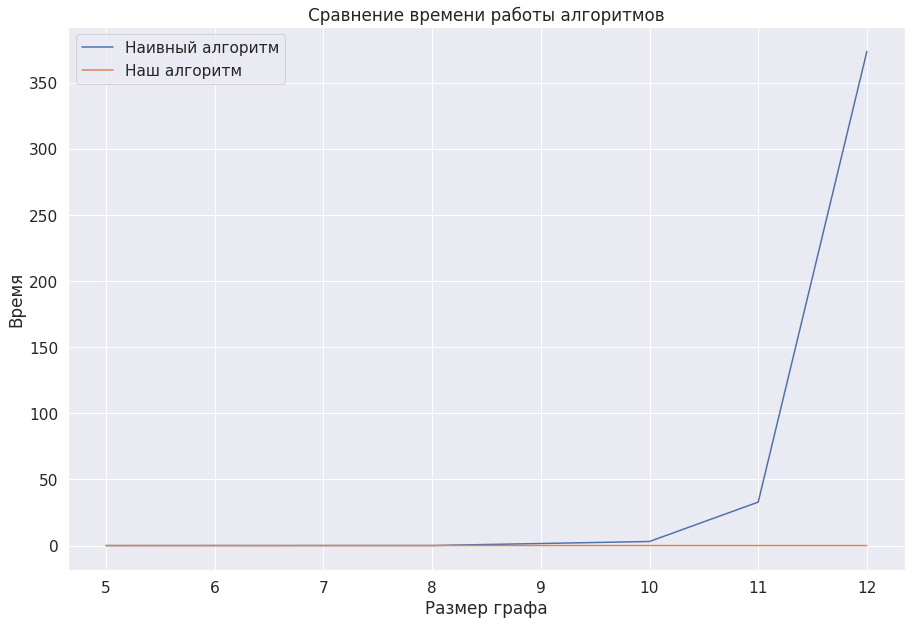

In [27]:
import seaborn as sns


naive_time = [tests_data[size][0] for size in sizes]
opt_time = [tests_data[size][1] for size in sizes]

sns.set(style="darkgrid", font_scale=1.4)
plt.figure(figsize=(15, 10))
plt.title('Сравнение времени работы алгоритмов')
plt.plot(
  sizes,
  naive_time,
  label='Наивный алгоритм'
)
plt.plot(
  sizes,
  opt_time,
  label='Наш алгоритм'
)
plt.xlabel('Размер графа')
plt.ylabel('Время')
plt.legend()
plt.show()

По графику видно, что уже при 11 вершинах время работы наивного алгоритма сильно превсходит время работы нашего алгоритма.

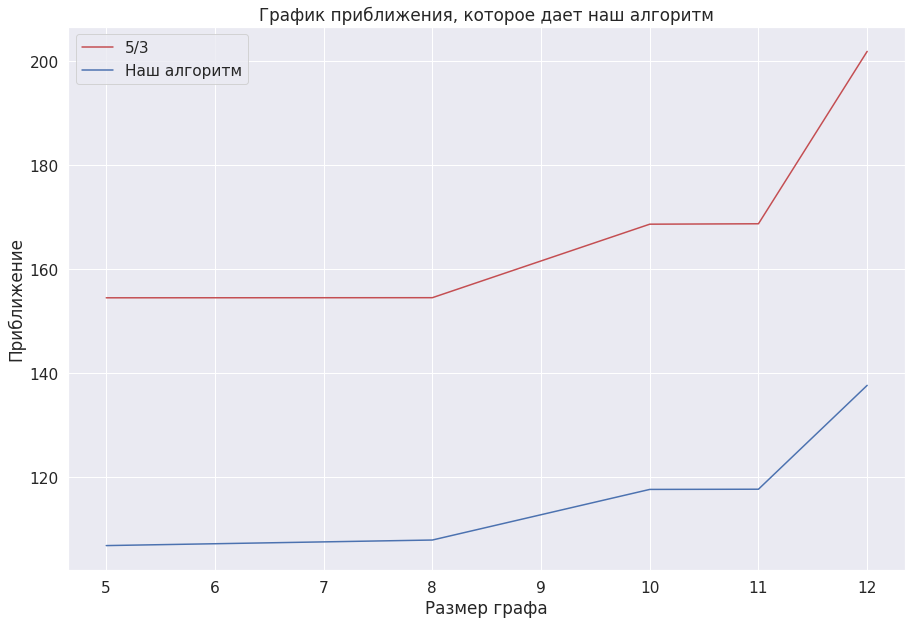

In [28]:
naive_len= np.array([tests_data[size][2] for size in sizes])
opt_len = np.array([tests_data[size][3] for size in sizes])
error = opt_len / naive_len
line = naive_len * 5/3.

plt.figure(figsize=(15, 10))
plt.title('График приближения, которое дает наш алгоритм')
plt.plot(
  sizes,
  line,
  label='5/3',
  color='r'
)
plt.plot(
  sizes,
  opt_len,
  label='Наш алгоритм'
)
plt.xlabel('Размер графа')
plt.ylabel('Приближение')
plt.legend()
plt.show()

По графику видно, что $weight(AlgoHamP ath) \leq \frac{5}{3}weight(OptimalHamPath)$